<a href="https://colab.research.google.com/github/sexymonster/Projects/blob/main/TeamProject/TomatoDataCustom1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.인트로

## 1-1. 패키지 로드

In [1]:
from google.colab import drive
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import matplotlib

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# 버전 오류를 잡아주는 코드
!pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 12.8 MB/s 
     |████████████████████████████████| 102 kB 36.6 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 4.7 MB 35.3 MB/s 
     |████████████████████████████████| 690 kB 54.1 MB/s 
     |████████████████████████████████| 9.8 MB 59.6 MB/s 
     |████████████████████████████████| 296 kB 50.9 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=c575629f2d0300fdb60d1bc58ebaf0ac42acd20d7a6d3f8c495e6c86648070ad
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
Successfully built htmlmin
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: requests
  

## 1-2. 데이터 로드

In [3]:
path = "/content/gdrive/MyDrive/tomato/"

In [4]:
file_list = os.listdir(path)
print(file_list)

['2020_0010076_01', '2021_0010056_03', '2019_0010057_01', '2021_0010056_01', '2020_0020738_01', '2021_0010056_02', '2020_0010070_01', '2020_0010057_01', '2019_0010071_01', '2021_0010070_01', '2021_0020738_01', '2021_0010071_01', '2021_0010076_01', '2021_0010071_02', '2021_0020760_01']


## 1-3. 데이터 형태 수정

In [5]:
# 농가 번호를 입력하면 그 농가의 생육 정보(live), 제어 정보(ctrl), 환경 정보(env)들을 출력해주는 함수
def dataset(file, path=path):
  try:
    live = pd.read_excel(path + file+ "/방울토마토_생육정보_일별.xlsx")
    live = live.rename(columns = live.iloc[0])
    live = live.drop(live.index[0])
  except:
    pass

  ctrl = pd.read_excel(path + file+ "/방울토마토_제어정보_일별.xlsx")
  ctrl = ctrl.rename(columns = ctrl.iloc[0])
  ctrl = ctrl.drop(ctrl.index[0])

  env = pd.read_excel(path + file+ "/방울토마토_환경정보_일별.xlsx")
  env = env.rename(columns = env.iloc[0])
  env = env.drop(env.index[0])
  env = env.drop(env.columns[[3,5,6,9,10,11,13,14,19]], axis = 1)

  try:
    return live, ctrl, env
  except:
    return ctrl,env

In [6]:
# 모든 농가 데이터에 각각 번호(예를들면 ctrl1, ctrl2처럼)를 붙여줘서 출력해줌
file_list = os.listdir(path)

i = 1
live_list = []
ctrl_list = []
env_list= []

for file in file_list:
  try:
    globals()["live"+str(i)], globals()["ctrl"+str(i)], globals()["env"+str(i)]  = dataset(file,path)
    # live_list.append(globals()["live"+str(i)])
    # ctrl_list.append(globals()["ctrl"+str(i)])
    # env_list.append(globals()["env"+str(i)])
  except:
    globals()["ctrl"+str(i)], globals()["env"+str(i)]  = dataset(file,path)
    # ctrl_list.append(globals()["ctrl"+str(i)])
    # env_list.append(globals()["env"+str(i)])
  i += 1
print(i-1, '개의 농장 데이터가 있습니다.')

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


15 개의 농장 데이터가 있습니다.


# 2. 전처리

## 2-1. 데이터 전처리 함수

adapt(df) : 필요한 컬럼들로만 이루어진 데이터 프레임 생성\
astype(df) : 데이터들의 타입 변경 

### 2-1-1. 필요없는 컬럼 삭제해주는 함수 adapt()

In [7]:
# 유효한 컬럼을 알려주는 함수
def effcolm(df):
  effective = []
  columns = list(df)

  # 유효한 컬럼 추출 (nan값 개수가 1/3 이하인 컬럼)
  for col in columns:
    num_nan = df[col].isnull().sum()

    if num_nan < len(df[col])/3:
      effective.append(col)
  
  # 전부 0으로 표기된 의미 없는 컬럼도 제거(Nan,0.0이 같이 있으면 2개로 표시됨)
  for col in effective:
    if len(df[col].unique()) < 3:
      effective.remove(col) 


  return effective
  

In [8]:
# 유효한 컬럼으로만 이루어진 데이터프레임 생성
def adapt(df):
  eff_col = effcolm(df)
  df = df[eff_col]
  
  return df

### 2-1-2. Date를 인덱스로 설정하는 함수 astype()

In [9]:
# dtype변경 함수

def astype(df):
  # 수집일, 조사일의 데이터 형태를 datetime으로 변경하고, 인덱스로 설정
  df['Date'] = pd.to_datetime(df.iloc[:,0],  errors='coerce')
  df = df.set_index(keys="Date", drop = True)
  df = df.drop(df.columns[0], axis=1)

  # 나머지 데이터들의 형태를 float으로 변경
  df = df.astype("float")

  return df

### 2-1-3. 생육 데이터 자료의 변화량을 구해주는 함수 delta()

In [10]:
# 생육 데이터 자료의 변화량을 구해주는 함수
def delta(live):
  live_new = live[["주차","최종화방번호(번)"]]
  live_new["생장길이변화(dcm)"] = live.sort_values("Date")["생장길이(cm)"].pct_change()
  live_new["생장길이변화(dcm)"] = live.sort_values("Date")["화방높이(cm)"].pct_change()
  live_new["줄기굵기변화(dmm)"] = live.sort_values("Date")["줄기굵기(mm)"].pct_change()
  live_new["엽장변화(dcm)"] = live.sort_values("Date")["엽장(cm)"].pct_change()
  live_new["엽폭변화(dcm)"] = live.sort_values("Date")["엽폭(cm)"].pct_change()
  live_new["엽수변화(개)"] = live.sort_values("Date")["엽수(개)"].pct_change()
  live_new["개화군변화(점)"] = live.sort_values("Date")["개화군(점)"].pct_change()
  live_new["착과군변화(점)"] = live.sort_values("Date")["착과군(점)"].pct_change()
  live_new["열매수변화(개)"] = live.sort_values("Date")["열매수(개)"].pct_change()

  return live_new

### 2-1-4. adapt() 와 astype()을 동시에 실행시켜주는 함수 changedata()

In [11]:
def changedata(df):
  df = adapt(df)
  df = astype(df)
  
  return df

### 2-1-5. 생육데이터를 일 단위로 데이터 증강 시켜주는 함수 augment()

In [12]:
def augment(df):
  df_idx = df.index.to_list()
  print()
  idx = []
  growlist = []

  df_new = pd.DataFrame(columns=['날짜', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)', '엽수(개)', 
                           '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)'])
  for i in range(len(df_idx)-1):
    start = df_idx[i]
    start_gr = df.iloc[i,1]
    start_ht = df.iloc[i,2]
    start_th = df.iloc[i,3]
    start_ll = df.iloc[i,4]
    start_lw = df.iloc[i,5]
    start_ln = df.iloc[i,6]
    start_gh = df.iloc[i,7]
    start_ck = df.iloc[i,8]
    start_tm = df.iloc[i,9]
    start_nb = df.iloc[i,10]


    end = df_idx[i+1]
    end_gr = df.iloc[i+1,1]
    end_ht = df.iloc[i+1,2]
    end_th = df.iloc[i+1,3]
    end_ll = df.iloc[i+1,4]
    end_lw = df.iloc[i+1,5]
    end_ln = df.iloc[i+1,6]
    end_gh = df.iloc[i+1,7]
    end_ck = df.iloc[i+1,8]
    end_tm = df.iloc[i+1,9]
    end_nb = df.iloc[i+1,10]

    # print(start,start_gr,end,end_gr)
    diff = end_gr - start_gr
    dates = pd.date_range(start,end)
    inter = len(dates) - 1

    for j in range(inter):
      day = dates[j]
      growth = start_gr + (end_gr - start_gr)*j/(inter)
      height = start_ht + (end_ht - start_ht)*j/(inter)
      thick = start_th + (end_th - start_th)*j/(inter)
      lea_len = start_ll + (end_ll - start_ll)*j/(inter)
      lea_wid = start_lw + (end_lw - start_lw)*j/(inter)
      lea_num = start_ln + (end_ln - start_ln)*j/(inter)
      gaehwa = start_gh + (end_gh - start_gh)*j/(inter)
      chaka = start_ck + (end_ck - start_ck)*j/(inter)
      tomato = start_tm + (end_tm - start_tm)*j/(inter)
      numb = start_nb + (end_nb - start_nb)*j/(inter)
      

      df_new = df_new.append(pd.DataFrame([[day, growth, height, thick, lea_len, lea_wid, lea_num, gaehwa, chaka, tomato, numb]], columns=['날짜', '생장길이(cm)', '화방높이(cm)', '줄기굵기(mm)', '엽장(cm)', '엽폭(cm)', '엽수(개)', 
                            '개화군(점)', '착과군(점)', '열매수(개)', '최종화방번호(번)']), ignore_index=True)
        
  
  df_new = astype(df_new)
  df_new = df_new.round(2)
  
  return df_new


## 2-2. 데이터 처리 과정

### 2-2-1. 환경데이터

In [13]:
env1 = changedata(env1)
env2 = changedata(env2)
env3 = changedata(env3)
env4 = changedata(env4)
env1 = changedata(env5)
env5 = changedata(env6)
env7 = changedata(env7)
env8 = changedata(env8)
env9 = changedata(env9)
env10 = changedata(env10)
env11 = changedata(env11)
env12 = changedata(env12)
env13 = changedata(env13)
env14 = changedata(env14)
env15 = changedata(env15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
env4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2021-12-18 to 2022-03-18
Empty DataFrame

In [15]:
# for i in range(len(new_live2)):
#   dlist = new_live2.index.to_list

#   for x in range(dlist[i],dlist[i+1]):
#       start = x
#       temp = new_live2[(new_live2["height"] >= start) & (new_live2["height"] < end)]
#       print("{}이상 {}미만 : {}".format(start, end, temp["height"].mean()))


### 2-2-2. 생육데이터

In [16]:
live1

,조사일,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
1,2021-06-10,19,0.0,0.0,12.45,498.0,511.8,12.75,4.25,6.5,44.5,0.0
2,2021-06-18,20,0.0,0.0,12.3,430.0,388.0,11.0,0.0,4.25,26.5,0.0


In [17]:
live1 = changedata(live1)
live2 = changedata(live2)
live3 = changedata(live3)
live4 = changedata(live4)
live5 = changedata(live5)
live6 = changedata(live6)
live7 = changedata(live7)
live8 = changedata(live8)
live9 = changedata(live9)
live10 = changedata(live10)
live11 = changedata(live11)
live12 = changedata(live12)
live13 = changedata(live13)
# live14 = changedata(live14) #14농가는 데이터가 없음
live15 = changedata(live15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
live2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2021-01-20 to 2021-06-30
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   주차         24 non-null     float64
 1   생장길이(cm)   24 non-null     float64
 2   화방높이(cm)   24 non-null     float64
 3   줄기굵기(mm)   24 non-null     float64
 4   엽장(cm)     24 non-null     float64
 5   엽폭(cm)     24 non-null     float64
 6   엽수(개)      24 non-null     float64
 7   개화군(점)     24 non-null     float64
 8   착과군(점)     24 non-null     float64
 9   열매수(개)     24 non-null     float64
 10  최종화방번호(번)  24 non-null     float64
dtypes: float64(11)
memory usage: 2.2 KB


In [19]:
live2

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2021-01-20,2.0,0.0,0.0,2.28,66.3,38.8,5.00,0.00,0.00,0.00,0.00
2021-01-27,3.0,65.0,0.0,3.02,101.3,60.0,8.50,0.00,0.00,0.00,0.00
2021-02-03,4.0,35.0,0.0,2.52,146.3,82.5,8.50,0.00,0.00,0.00,0.00
2021-02-09,5.0,47.5,0.0,2.39,146.3,96.3,11.25,0.00,0.00,0.00,0.00
2021-02-17,6.0,67.5,0.0,3.44,165.0,115.0,12.50,0.00,0.00,0.00,0.00
2021-02-24,7.0,62.3,0.0,6.01,242.5,156.3,14.00,0.00,0.00,0.00,0.00
2021-03-03,8.0,32.5,0.0,4.72,212.5,132.5,11.75,0.00,0.00,0.00,0.00
2021-03-10,9.0,61.0,42.5,6.35,265.0,155.0,14.75,0.20,0.00,0.00,1.25
2021-03-17,10.0,62.5,115.0,7.69,323.8,259.8,17.00,0.83,0.00,0.00,3.50


### 2-2-2(1). 생육데이터 증강

In [20]:
# new_live1 = augment(live1)
new_live2 = augment(live2)
new_live3 = augment(live3)
new_live4 = augment(live4)
new_live5 = augment(live5)
# new_live6 = augment(live6)
new_live7 = augment(live7)
new_live8 = augment(live8)
new_live9 = augment(live9)
# new_live10 = augment(live10)
new_live11 = augment(live11)
new_live12 = augment(live12)
new_live13 = augment(live13)
# new_live14 = augment(live14)
new_live15 = augment(live15)

In [21]:
new_live2

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-01-20,0.00,0.0,2.28,66.30,38.80,5.00,0.0,0.00,0.00,0.00
2021-01-21,9.29,0.0,2.39,71.30,41.83,5.50,0.0,0.00,0.00,0.00
2021-01-22,18.57,0.0,2.49,76.30,44.86,6.00,0.0,0.00,0.00,0.00
2021-01-23,27.86,0.0,2.60,81.30,47.89,6.50,0.0,0.00,0.00,0.00
2021-01-24,37.14,0.0,2.70,86.30,50.91,7.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
2021-06-25,0.00,0.0,6.44,368.93,295.66,11.39,0.0,3.29,22.21,3.29
2021-06-26,0.00,0.0,6.45,367.14,293.09,11.21,0.0,3.18,20.32,3.18
2021-06-27,0.00,0.0,6.47,365.36,290.51,11.04,0.0,3.07,18.43,3.07


In [22]:
del_live2 = delta(live2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [23]:
new_live2.iloc[70:80,:].round(2)

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-03-31,45.00,130.00,8.88,365.00,266.00,17.75,1.05,0.95,1.25,5.00
2021-04-01,43.86,124.11,8.59,354.76,255.86,17.25,1.05,0.94,1.39,4.93
2021-04-02,42.71,118.23,8.29,344.51,245.71,16.75,1.05,0.93,1.54,4.86
2021-04-03,41.57,112.34,8.00,334.27,235.57,16.25,1.05,0.92,1.68,4.79
2021-04-04,40.43,106.46,7.70,324.03,225.43,15.75,1.05,0.91,1.82,4.71
2021-04-05,39.29,100.57,7.41,313.79,215.29,15.25,1.05,0.90,1.96,4.64
2021-04-06,38.14,94.69,7.11,303.54,205.14,14.75,1.05,0.89,2.11,4.57
2021-04-07,37.00,88.80,6.82,293.30,195.00,14.25,1.05,0.88,2.25,4.50
2021-04-08,38.86,103.61,7.18,305.54,205.71,13.57,0.97,1.01,3.04,4.43


### 2-2-3. 제어 데이터

In [24]:
ctrl1 = changedata(ctrl1)
ctrl2 = changedata(ctrl2)
ctrl3 = changedata(ctrl3)
ctrl4 = changedata(ctrl4)
ctrl5 = changedata(ctrl5)
ctrl6 = changedata(ctrl6)
ctrl7 = changedata(ctrl7)
ctrl8 = changedata(ctrl8)
ctrl9 = changedata(ctrl9)
ctrl10 = changedata(ctrl10)
ctrl11 = changedata(ctrl11)
ctrl12 = changedata(ctrl12)
ctrl13 = changedata(ctrl13)
ctrl14 = changedata(ctrl14)
ctrl15 = changedata(ctrl15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
ctrl2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 2021-01-12 to 2021-06-30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   좌측일중천창 작동여부  169 non-null    float64
 1   우측일중천창 작동여부  169 non-null    float64
 2   좌측이중천창 작동여부  169 non-null    float64
 3   우측이중천창 작동여부  169 non-null    float64
 4   좌측일중측창 작동여부  169 non-null    float64
 5   차광커튼작동상태     168 non-null    float64
dtypes: float64(6)
memory usage: 9.2 KB


In [26]:
ctrl2

,좌측일중천창 작동여부,우측일중천창 작동여부,좌측이중천창 작동여부,우측이중천창 작동여부,좌측일중측창 작동여부,차광커튼작동상태
Date,,,,,,
2021-01-12,0.00,0.00,0.00,0.00,6.29,31.56
2021-01-13,0.00,0.00,0.00,0.00,16.24,35.00
2021-01-14,1.20,0.05,0.00,0.00,15.27,42.54
2021-01-15,0.00,0.00,0.00,0.00,10.08,41.67
2021-01-16,0.00,0.00,0.00,0.00,9.23,33.33
...,...,...,...,...,...,...
2021-06-26,53.74,62.63,16.87,31.88,43.87,98.42
2021-06-27,73.96,98.82,36.40,43.77,50.52,97.51
2021-06-28,82.90,85.16,30.76,40.77,50.29,98.72


# 3. 시각화

In [27]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=new_live2.index, y=new_live2['화방높이(cm)'], mode='lines+markers', name='height'))
fig.add_trace(go.Scatter(x=new_live2.index, y=new_live2['줄기굵기(mm)'], mode='lines+markers', name='tick'))
fig.add_trace(go.Scatter(x=new_live2.index, y=new_live2['엽장(cm)'], mode='lines+markers', name='leaf_len'))
fig.add_trace(go.Scatter(x=new_live2.index, y=new_live2['엽폭(cm)'], mode='lines+markers', name='leaf_wide'))
fig.add_trace(go.Scatter(x=new_live2.index, y=new_live2['열매수(개)'], mode='lines+markers', name='tomato'))


fig.update_layout(
    title='Farm 1 (Jan 2018 - Jan 2020)',
    xaxis_title='Date', yaxis_title='lenght(cm)'
)

In [28]:
# fig, ax1 = plt.subplots()
# ax1.plot()

## 3-1. live

In [29]:
print(live2.corr())

                 주차  생장길이(cm)  화방높이(cm)  줄기굵기(mm)    엽장(cm)    엽폭(cm)  \
주차         1.000000 -0.412521  0.050332  0.445992  0.739724  0.787115   
생장길이(cm)  -0.412521  1.000000  0.542720  0.160292 -0.085487 -0.220019   
화방높이(cm)   0.050332  0.542720  1.000000  0.706385  0.464763  0.370209   
줄기굵기(mm)   0.445992  0.160292  0.706385  1.000000  0.871426  0.797572   
엽장(cm)     0.739724 -0.085487  0.464763  0.871426  1.000000  0.974690   
엽폭(cm)     0.787115 -0.220019  0.370209  0.797572  0.974690  1.000000   
엽수(개)      0.156551  0.360195  0.378990  0.606898  0.595988  0.507825   
개화군(점)     0.225424  0.358743  0.702861  0.556031  0.437203  0.338765   
착과군(점)     0.826232 -0.237101  0.027184  0.139683  0.417512  0.448837   
열매수(개)     0.731368 -0.325822 -0.170435  0.023386  0.345404  0.380361   
최종화방번호(번)  0.733735  0.041079  0.456737  0.481204  0.605250  0.576442   

              엽수(개)    개화군(점)    착과군(점)    열매수(개)  최종화방번호(번)  
주차         0.156551  0.225424  0.826232  0.731368   0.733735

In [30]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=env1.index, y=env1['내부습도(%)'], mode='lines+markers', name='sub1'))
fig.add_trace(go.Scatter(x=env1.index, y=env1['내부온도(도)'], mode='lines+markers', name='tem1'))
fig.add_trace(go.Scatter(x=env1.index, y=env1['일사량(W/m-2·s)'], mode='lines+markers', name='sun1'))

fig.add_trace(go.Scatter(x=env3.index, y=env3['내부습도(%)'], mode='lines+markers', name='sub3'))
fig.add_trace(go.Scatter(x=env3.index, y=env3['내부온도(도)'], mode='lines+markers', name='tem3'))
fig.add_trace(go.Scatter(x=env3.index, y=env3['일사량(W/m-2·s)'], mode='lines+markers', name='sun3'))

In [31]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=env1.index, y=env1['내부온도(도)'], mode='lines+markers', name='tem1'))

fig.add_trace(go.Scatter(x=env2.index, y=env2['내부온도(도)'], mode='lines+markers', name='tem2'))

fig.add_trace(go.Scatter(x=env3.index, y=env3['내부온도(도)'], mode='lines+markers', name='tem3'))


In [32]:
fig = go.Figure()
# we subtract 1 to stocks price data to show performance
fig.add_trace(go.Scatter(x=live2.index, y=live2['열매수(개)'], mode='lines+markers', name='tomato2'))
fig.add_trace(go.Scatter(x=live3.index, y=live3['열매수(개)'], mode='lines+markers', name='tomato3'))
fig.add_trace(go.Scatter(x=live4.index, y=live4['열매수(개)'], mode='lines+markers', name='tomato4'))
fig.add_trace(go.Scatter(x=live5.index, y=live5['열매수(개)'], mode='lines+markers', name='tomato5'))
fig.add_trace(go.Scatter(x=live7.index, y=live7['열매수(개)'], mode='lines+markers', name='tomato7'))
fig.add_trace(go.Scatter(x=live8.index, y=live8['열매수(개)'], mode='lines+markers', name='tomato8'))
fig.add_trace(go.Scatter(x=live9.index, y=live9['열매수(개)'], mode='lines+markers', name='tomato9'))
fig.add_trace(go.Scatter(x=live11.index, y=live11['열매수(개)'], mode='lines+markers', name='tomato11'))
fig.add_trace(go.Scatter(x=live12.index, y=live12['열매수(개)'], mode='lines+markers', name='tomato12'))
fig.add_trace(go.Scatter(x=live13.index, y=live13['열매수(개)'], mode='lines+markers', name='tomato13'))
fig.add_trace(go.Scatter(x=live15.index, y=live15['열매수(개)'], mode='lines+markers', name='tomato15'))

In [33]:
new_live2.iloc[:10,:]

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-01-20,0.00,0.0,2.28,66.30,38.80,5.0,0.0,0.0,0.0,0.0
2021-01-21,9.29,0.0,2.39,71.30,41.83,5.5,0.0,0.0,0.0,0.0
2021-01-22,18.57,0.0,2.49,76.30,44.86,6.0,0.0,0.0,0.0,0.0
2021-01-23,27.86,0.0,2.60,81.30,47.89,6.5,0.0,0.0,0.0,0.0
2021-01-24,37.14,0.0,2.70,86.30,50.91,7.0,0.0,0.0,0.0,0.0
2021-01-25,46.43,0.0,2.81,91.30,53.94,7.5,0.0,0.0,0.0,0.0
2021-01-26,55.71,0.0,2.91,96.30,56.97,8.0,0.0,0.0,0.0,0.0
2021-01-27,65.00,0.0,3.02,101.30,60.00,8.5,0.0,0.0,0.0,0.0
2021-01-28,60.71,0.0,2.95,107.73,63.21,8.5,0.0,0.0,0.0,0.0


In [34]:
live3.iloc[5:15,:]

,주차,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,,
2020-01-11,15.0,162.5,537.5,3.17,177.5,110.0,2.00,10.02,9.44,6.50,11.00
2020-01-18,16.0,170.0,112.5,7.33,240.0,155.0,2.50,11.11,10.37,8.00,12.00
2020-01-28,17.0,255.0,180.0,9.53,390.0,260.0,19.50,12.32,11.08,8.00,13.00
2020-02-01,18.0,77.5,195.0,12.11,327.5,285.0,0.75,12.65,11.42,0.00,13.25
2020-02-08,19.0,177.5,302.5,12.53,342.5,290.0,3.00,13.02,12.35,8.50,13.75
2020-02-15,20.0,115.0,235.0,10.38,247.5,220.0,5.25,13.92,13.03,47.75,14.50
2020-02-22,21.0,127.5,270.0,10.97,252.5,207.5,10.50,14.13,13.43,44.50,15.00
2020-02-29,22.0,162.5,277.5,11.43,292.5,135.8,10.00,14.22,13.56,46.00,15.00
2020-03-07,23.0,255.0,305.0,11.79,332.5,215.0,11.50,14.91,14.12,56.00,15.50


In [35]:
corr_df = live2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr']) # s==1 은 자기자신이기 때문에 제외
df.style.background_gradient(cmap='viridis')

,,corr
엽폭(cm),엽장(cm),0.970000
엽장(cm),엽폭(cm),0.970000
착과군(점),열매수(개),0.920000
열매수(개),착과군(점),0.920000
줄기굵기(mm),엽장(cm),0.870000
엽장(cm),줄기굵기(mm),0.870000
착과군(점),최종화방번호(번),0.860000
최종화방번호(번),착과군(점),0.860000
주차,착과군(점),0.830000
착과군(점),주차,0.830000


## 3-2. env

In [36]:
print(env2.corr())

              내부CO2(ppm)   내부습도(%)      강우감지  일사량(W/m-2·s)   외부온도(도)  \
내부CO2(ppm)      1.000000 -0.190374  0.106662     -0.422267 -0.741889   
내부습도(%)        -0.190374  1.000000  0.405624     -0.304710  0.344375   
강우감지            0.106662  0.405624  1.000000     -0.510946  0.053641   
일사량(W/m-2·s)   -0.422267 -0.304710 -0.510946      1.000000  0.466237   
외부온도(도)        -0.741889  0.344375  0.053641      0.466237  1.000000   
내부온도(도)        -0.732016  0.135669 -0.137231      0.575753  0.821146   
지온(도)          -0.759758  0.151117 -0.084324      0.447783  0.907718   
외부풍속(m/s)      -0.104698  0.054309  0.093670     -0.064576  0.001221   

               내부온도(도)     지온(도)  외부풍속(m/s)  
내부CO2(ppm)   -0.732016 -0.759758  -0.104698  
내부습도(%)       0.135669  0.151117   0.054309  
강우감지         -0.137231 -0.084324   0.093670  
일사량(W/m-2·s)  0.575753  0.447783  -0.064576  
외부온도(도)       0.821146  0.907718   0.001221  
내부온도(도)       1.000000  0.944606  -0.158054  
지온(도)         0.944606  1.000

In [37]:
corr_df = env2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

,,corr
내부온도(도),지온(도),0.940000
지온(도),내부온도(도),0.940000
외부온도(도),지온(도),0.910000
지온(도),외부온도(도),0.910000
내부온도(도),외부온도(도),0.820000
외부온도(도),내부온도(도),0.820000
내부온도(도),일사량(W/m-2·s),0.580000
일사량(W/m-2·s),내부온도(도),0.580000
외부온도(도),일사량(W/m-2·s),0.470000
일사량(W/m-2·s),외부온도(도),0.470000


## 3-3. ctrl

In [38]:
print(ctrl2.corr())

             좌측일중천창 작동여부  우측일중천창 작동여부  좌측이중천창 작동여부  우측이중천창 작동여부  좌측일중측창 작동여부  \
좌측일중천창 작동여부     1.000000     0.924604     0.858802     0.841724     0.895373   
우측일중천창 작동여부     0.924604     1.000000     0.789814     0.907732     0.870756   
좌측이중천창 작동여부     0.858802     0.789814     1.000000     0.852091     0.818982   
우측이중천창 작동여부     0.841724     0.907732     0.852091     1.000000     0.833715   
좌측일중측창 작동여부     0.895373     0.870756     0.818982     0.833715     1.000000   
차광커튼작동상태        0.737078     0.739025     0.553559     0.588440     0.672576   

             차광커튼작동상태  
좌측일중천창 작동여부  0.737078  
우측일중천창 작동여부  0.739025  
좌측이중천창 작동여부  0.553559  
우측이중천창 작동여부  0.588440  
좌측일중측창 작동여부  0.672576  
차광커튼작동상태     1.000000  


In [39]:
corr_df = ctrl2.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
# corr_df

s = corr_df.unstack()
# s

df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

In [40]:
env2.columns

Index(['내부CO2(ppm)', '내부습도(%)', '강우감지', '일사량(W/m-2·s)', '외부온도(도)', '내부온도(도)',
       '지온(도)', '외부풍속(m/s)'],
      dtype='object')

In [41]:
new_live2

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-01-20,0.00,0.0,2.28,66.30,38.80,5.00,0.0,0.00,0.00,0.00
2021-01-21,9.29,0.0,2.39,71.30,41.83,5.50,0.0,0.00,0.00,0.00
2021-01-22,18.57,0.0,2.49,76.30,44.86,6.00,0.0,0.00,0.00,0.00
2021-01-23,27.86,0.0,2.60,81.30,47.89,6.50,0.0,0.00,0.00,0.00
2021-01-24,37.14,0.0,2.70,86.30,50.91,7.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
2021-06-25,0.00,0.0,6.44,368.93,295.66,11.39,0.0,3.29,22.21,3.29
2021-06-26,0.00,0.0,6.45,367.14,293.09,11.21,0.0,3.18,20.32,3.18
2021-06-27,0.00,0.0,6.47,365.36,290.51,11.04,0.0,3.07,18.43,3.07


In [42]:
df_merge2 = pd.merge(new_live2, env2, left_index=True, right_index=True, how='outer')
df_merge3 = pd.merge(new_live3, env3, left_index=True, right_index=True, how='outer')
df_merge4 = pd.merge(new_live4, env4, left_index=True, right_index=True, how='outer')
df_merge5 = pd.merge(new_live5, env5, left_index=True, right_index=True, how='outer')
df_merge7 = pd.merge(new_live7, env7, left_index=True, right_index=True, how='outer')
df_merge8 = pd.merge(new_live8, env8, left_index=True, right_index=True, how='outer')
df_merge9 = pd.merge(new_live9, env9, left_index=True, right_index=True, how='outer')
df_merge11 = pd.merge(new_live11, env11, left_index=True, right_index=True, how='outer')
df_merge12 = pd.merge(new_live12, env12, left_index=True, right_index=True, how='outer')
df_merge13 = pd.merge(new_live13, env13, left_index=True, right_index=True, how='outer')
df_merge14 = pd.merge(new_live15, env14, left_index=True, right_index=True, how='outer')

In [43]:
df_merge2.corr()

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번),내부CO2(ppm),내부습도(%),강우감지,일사량(W/m-2·s),외부온도(도),내부온도(도),지온(도),외부풍속(m/s)
생장길이(cm),1.000000,0.569278,0.120635,-0.171807,-0.304146,0.285395,0.359346,-0.291290,-0.416922,-0.010399,0.513304,-0.086459,-0.053249,-0.213789,-0.501718,-0.645067,-0.664122,0.170300
화방높이(cm),0.569278,1.000000,0.730971,0.479626,0.370166,0.403314,0.739370,0.025147,-0.195507,0.462297,0.290625,0.090976,0.015778,0.133478,0.041806,-0.245469,-0.365425,0.151719
줄기굵기(mm),0.120635,0.730971,1.000000,0.873769,0.791941,0.632646,0.616063,0.120416,0.005362,0.485559,-0.025555,0.149846,0.048904,0.292491,0.399292,0.131602,-0.218086,0.109770
엽장(cm),-0.171807,0.479626,0.873769,1.000000,0.977641,0.591891,0.489785,0.420200,0.353950,0.625061,-0.385531,0.243552,0.036320,0.419396,0.681440,0.479477,0.414616,0.018381
엽폭(cm),-0.304146,0.370166,0.791941,0.977641,1.000000,0.509874,0.373629,0.453753,0.396472,0.592365,-0.465187,0.250824,0.024078,0.441592,0.734248,0.585427,0.563443,-0.009846
엽수(개),0.285395,0.403314,0.632646,0.591891,0.509874,1.000000,0.516753,-0.021868,-0.022430,0.330392,0.074138,-0.069152,0.060472,0.116274,0.121591,-0.055204,-0.395343,0.086683
개화군(점),0.359346,0.739370,0.616063,0.489785,0.373629,0.516753,1.000000,0.332238,0.253670,0.735443,0.006799,0.010692,0.087247,0.192119,0.248279,-0.112426,-0.263761,0.134026
착과군(점),-0.291290,0.025147,0.120416,0.420200,0.453753,-0.021868,0.332238,1.000000,0.929288,0.859751,-0.733432,0.330542,0.083115,0.380343,0.771668,0.593601,0.656676,-0.011861
열매수(개),-0.416922,-0.195507,0.005362,0.353950,0.396472,-0.022430,0.253670,0.929288,1.000000,0.735834,-0.757642,0.280294,0.086097,0.315376,0.706941,0.565204,0.603384,-0.060981
최종화방번호(번),-0.010399,0.462297,0.485559,0.625061,0.592365,0.330392,0.735443,0.859751,0.735834,1.000000,-0.494120,0.266939,0.103494,0.387556,0.699618,0.389811,0.389367,0.065897


# Modeling

생육, 환경 데이터 df_merge1,df_merge2,df_merge3,df_merge4

In [45]:
df_merge4.head()

,생장길이(cm),화방높이(cm),줄기굵기(mm),엽장(cm),엽폭(cm),엽수(개),개화군(점),착과군(점),열매수(개),최종화방번호(번)
Date,,,,,,,,,,
2021-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# 농가 2) Nan값 삭제
ndf_merge2 = df_merge2[df_merge2["열매수(개)"].isnull() == False ]
ndf_merge2 = ndf_merge2[ndf_merge2["외부온도(도)"].isnull() == False ]
# ndf_merge2 = ndf_merge2.iloc[:-3 , :]

In [45]:
# 농가 12) Nan값 삭제
ndf_merge12 = df_merge12[df_merge12["열매수(개)"].isnull() == False ]
ndf_merge12 = ndf_merge12[ndf_merge12["내부온도(도)"].isnull() == False ]


In [46]:
# 농가 8) Nan값 삭제
ndf_merge8 = df_merge8[df_merge8["열매수(개)"].isnull() == False ]
ndf_merge8 = ndf_merge8[df_merge8["내부습도(%)"].isnull() == False ]
# ndf_merge3 = ndf_merge3[df_merge3["지온(도)"].isnull() == False ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



## 4-1. LSTM

In [55]:
# 농가 2로 학습하고 농가 12로 테스트
x = array(ndf_merge2[["내부습도(%)","일사량(W/m-2·s)","외부온도(도)","내부온도(도)"]])
y = array(ndf_merge2["열매수(개)"])

x_12 = array(ndf_merge12[["내부습도(%)","일사량(W/m-2·s)","외부온도(도)","내부온도(도)"]])
y_12 = array(ndf_merge12["열매수(개)"])

In [57]:

print(x.shape)
print(y.shape)
x = x.reshape((x.shape[0], x.shape[1],1))
print(x.shape)

model = Sequential()
model.add(LSTM(20, activation = "relu", input_shape = (4,1)))
model.add(Dense(5))
model.add(Dense(1))
model.summary()


model.compile(optimizer = "adam", loss = "mse")

early_stopping = EarlyStopping(monitor = "loss", patience = 100, mode = "auto")

# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
history = model.fit(x, y, 
                    epochs = 1000,
                    batch_size = 1,
                    verbose = 2,
                    callbacks = [early_stopping],
                    validation_data=(x_12,y_12))

(160, 4, 1)
(160,)
(160, 4, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                1760      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
160/160 - 5s - loss: 521.6853 - val_loss: 669.5251 - 5s/epoch - 34ms/step
Epoch 2/1000
160/160 - 1s - loss: 332.7179 - val_loss: 728.7681 - 966ms/epoch - 6ms/step
Epoch 3/1000
160/160 - 1s - loss: 285.6693 - val_loss: 436.2604 - 963ms/epoch - 6ms/step
Epoch 4/1000
160/160

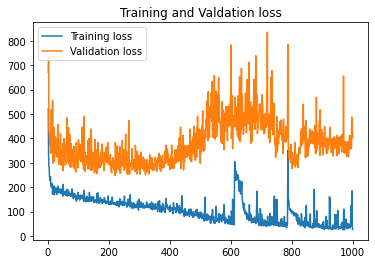

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()

주기가 다른 두 농가로 학습시키고 검증한 결과
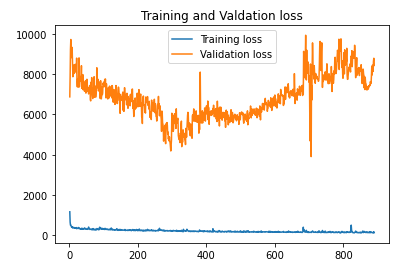

### 4-1-1. 특징값 정규화

Min-Max 정규화

In [ ]:
# normalization_df = (df - df.mean())/df.std()
# normalization_df.head()

In [60]:
x = array(ndf_merge2[["내부습도(%)","일사량(W/m-2·s)","내부온도(도)"]])
y = array(ndf_merge2["열매수(개)"])

x_12 = array(ndf_merge12[["내부습도(%)","일사량(W/m-2·s)","내부온도(도)"]])
y_12 = array(ndf_merge12["열매수(개)"])

x1_norm = (x-x.mean())/x.std()
x12_norm = (x_12-x_12.mean())/x_12.std()

print(x1_norm.shape)
print(y.shape)
x1_norm = x1_norm.reshape((x1_norm.shape[0], x1_norm.shape[1],1))
print(x1_norm.shape)

model = Sequential()
model.add(LSTM(10, activation = "relu", input_shape = (3,1)))
model.add(Dense(5))
model.add(Dense(1))
model.summary()


model.compile(optimizer = "adam", loss = "mse")

early_stopping = EarlyStopping(monitor = "loss", patience = 100, mode = "auto")

# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
history1 = model.fit(x1_norm, y, 
                    epochs = 1000,
                    batch_size = 1,
                    verbose = 2,
                    callbacks = [early_stopping],
                    validation_data=(x12_norm,y_12))

(160, 3)
(160,)
(160, 3, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
160/160 - 5s - loss: 942.2337 - val_loss: 1586.2916 - 5s/epoch - 34ms/step
Epoch 2/1000
160/160 - 2s - loss: 861.5345 - val_loss: 1383.3088 - 2s/epoch - 12ms/step
Epoch 3/1000
160/160 - 2s - loss: 695.3564 - val_loss: 1139.9949 - 2s/epoch - 10ms/step
Epoch 4/1000
160/160 - 2s - 

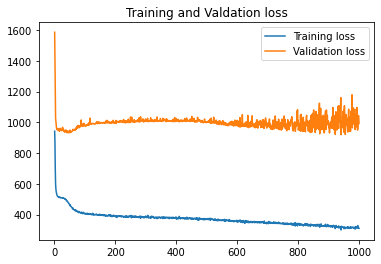

In [61]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()

In [62]:
x = array(ndf_merge2[["내부습도(%)","내부CO2(ppm)","일사량(W/m-2·s)","내부온도(도)"]])
y = array(ndf_merge2["열매수(개)"])

x_12 = array(ndf_merge12[["내부습도(%)","내부CO2(ppm)","일사량(W/m-2·s)","내부온도(도)"]])
y_12 = array(ndf_merge12["열매수(개)"])

x1_norm = (x-x.mean())/x.std()
x12_norm = (x_12-x_12.mean())/x_12.std()

print(x1_norm.shape)
print(y.shape)
x1_norm = x1_norm.reshape((x1_norm.shape[0], x1_norm.shape[1],1))
print(x1_norm.shape)

model = Sequential()
model.add(LSTM(10, activation = "relu", input_shape = (4,1)))
model.add(Dense(5))
model.add(Dense(1))
model.summary()


model.compile(optimizer = "adam", loss = "mse")

early_stopping = EarlyStopping(monitor = "loss", patience = 100, mode = "auto")

# loss값을 모니터해서 과적합이 생기면 100번 더 돌고 끊음
# mode=auto loss면 최저값이100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지
# mode=min, mode=max
history2 = model.fit(x1_norm, y, 
                    epochs = 1000,
                    batch_size = 1,
                    verbose = 2,
                    callbacks = [early_stopping],
                    validation_data=(x12_norm,y_12))

(160, 4)
(160,)
(160, 4, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                480       
                                                                 
 dense_6 (Dense)             (None, 5)                 55        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
160/160 - 2s - loss: 929.3869 - val_loss: 1538.2925 - 2s/epoch - 12ms/step
Epoch 2/1000
160/160 - 1s - loss: 760.6053 - val_loss: 1164.0106 - 1s/epoch - 8ms/step
Epoch 3/1000
160/160 - 1s - loss: 645.2919 - val_loss: 1095.5254 - 1s/epoch - 6ms/step
Epoch 4/1000
160/160 - 1s - lo

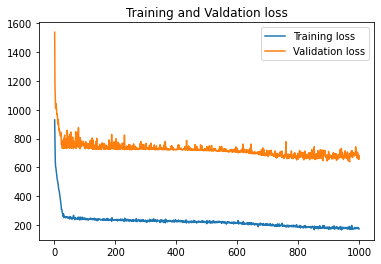

In [63]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [51]:
splitter = KFold(n_splits=5, shuffle=True, random_state=1)

sta_rafo = Pipeline([("scaler",StandardScaler()),("model",RandomForestRegressor(n_jobs=-1, random_state=1))])

x = ndf_merge2[["내부습도(%)","내부CO2(ppm)","일사량(W/m-2·s)","내부온도(도)"]]
y = ndf_merge2["열매수(개)"]

result_train = []
result_predict = []
result_rmse = []
result_mae = []
result_r2 = []

# result_loss

for i, ii in splitter.split(x, y):

    train_x, train_y = x.iloc[i], y.iloc[i]
    test_x, test_y = x.iloc[ii], y.iloc[ii]

    reg = sta_rafo.fit(train_x, train_y)

    result_train.append(reg.score(train_x, train_y))
    result_predict.append(reg.score(test_x, test_y))

    print('train score : ', reg.score(train_x, train_y))
    print('test score : ',  reg.score(test_x, test_y))

    pred_ranfo = sta_rafo.predict(test_x)
    rmse = mean_squared_error(test_y, pred_ranfo)**0.5
    print("RMSE :", rmse)
    result_rmse.append(rmse)


    mae = mean_absolute_error(test_y, pred_ranfo)
    print("MAE :", mae)
    result_mae.append(mae)


    x_data = np.array(test_y)
    y_data = np.array(pred_ranfo)

    r2 = r2_score(x_data, y_data)
    print("r2_score :", r2)
    result_r2.append(r2)

    print("\n")



print("학습률 평균 : ",np.array(result_train).mean())
print("예측률 평균 : ",np.array(result_predict).mean())
print("RMSE 평균 : ",np.array(result_rmse).mean())
print("MAE 평균 : ",np.array(result_mae).mean())
print("R2_SCORE 평균 : ",np.array(result_r2).mean())

train score :  0.9565984016992956
test score :  0.034652144036939836
RMSE : 16.796546181981505
MAE : 10.640765625
r2_score : 0.034652144036939836


train score :  0.9575137653260405
test score :  0.762739339092427
RMSE : 11.513336752476997
MAE : 7.565340625000003
r2_score : 0.7627393390924269


train score :  0.9514142075869906
test score :  0.754575230654307
RMSE : 13.76949087084151
MAE : 9.581853125000002
r2_score : 0.754575230654307


train score :  0.9547833070336101
test score :  0.8525853042476301
RMSE : 8.929274995905322
MAE : 5.724175000000001
r2_score : 0.8525853042476301


train score :  0.9498924433699937
test score :  0.715090084661282
RMSE : 13.981855612252442
MAE : 9.174768750000005
r2_score : 0.715090084661282


학습률 평균 :  0.9540404250031861
예측률 평균 :  0.6239284205385172
RMSE 평균 :  12.998100882691555
MAE 평균 :  8.537380625000003
R2_SCORE 평균 :  0.6239284205385172
